In [3]:
import os
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
sns.set_style('whitegrid')
import pandas as pd
import numpy as np

In [4]:
os.getcwd()

'/home/tduricic/Development/workspace/elliot/notebooks'

In [5]:
lastfm_ratings_filename = '../data/lastfm/processed/ratings.tsv'
def create_ratings_bipartite_graph(filename):
    users = set()
    items = set()
    user_items_dict = {}
    edges = []
    with open(filename) as fr:
        for line in fr.readlines():
            tokens = line.split()
            userId = tokens[0]
            itemId = tokens[1]
            # For now we omit the weight
            # rating = float(tokens[2])

            users.add(userId)
            items.add(itemId)
            edges.append((userId, itemId))
            if userId not in user_items_dict:
                user_items_dict[userId] = []
                user_items_dict[userId].append(itemId)
            else:
                user_items_dict[userId].append(itemId)
    B = nx.Graph()
    B.add_nodes_from(users, bipartite=0)
    B.add_nodes_from(items, bipartite=1)
    B.add_edges_from(edges)

    return B, user_items_dict, users, items

In [6]:
B, user_items_dict, users, items = create_ratings_bipartite_graph(lastfm_ratings_filename)

In [7]:
projected_G = bipartite.projected_graph(B, items)

In [38]:
print(len(projected_G.edges))

3343783


In [8]:
partition = community_louvain.best_partition(projected_G)

In [40]:
partition

{'98639': 0,
 '32163': 1,
 '39877': 2,
 '76874': 3,
 '56947': 2,
 '103220': 4,
 '27540': 1,
 '95563': 5,
 '89754': 0,
 '17714': 1,
 '129981': 2,
 '15354': 1,
 '76685': 3,
 '5811': 3,
 '86589': 2,
 '68974': 2,
 '27501': 3,
 '29896': 6,
 '37292': 2,
 '121342': 4,
 '14740': 7,
 '72161': 2,
 '13148': 3,
 '43193': 1,
 '94386': 4,
 '38404': 0,
 '89595': 2,
 '127799': 2,
 '21033': 7,
 '25261': 3,
 '131780': 21,
 '58621': 0,
 '86444': 2,
 '134884': 4,
 '31167': 0,
 '92033': 3,
 '46757': 2,
 '38171': 2,
 '36810': 0,
 '119834': 4,
 '69183': 2,
 '74025': 4,
 '86653': 0,
 '76084': 2,
 '27164': 3,
 '110617': 2,
 '132679': 4,
 '88269': 4,
 '65676': 3,
 '62452': 9,
 '118461': 0,
 '91679': 1,
 '67733': 3,
 '56840': 3,
 '58154': 2,
 '50740': 2,
 '113728': 3,
 '34684': 1,
 '65499': 4,
 '125719': 2,
 '103286': 4,
 '134679': 3,
 '55285': 2,
 '60779': 3,
 '134348': 2,
 '65965': 3,
 '89498': 4,
 '41052': 2,
 '79348': 2,
 '122260': 2,
 '25033': 0,
 '129172': 7,
 '59618': 4,
 '4174': 1,
 '112752': 4,
 '74693'

In [9]:
community_lists = {}
for key in partition:
    if partition[key] not in community_lists:
        community_lists[partition[key]] = []
        community_lists[partition[key]].append(key)
    else:
        community_lists[partition[key]].append(key)

In [10]:
len(community_lists)

12

In [11]:
community_sizes = {}
for key in community_lists:
    community_sizes[key] = len(community_lists[key])

In [12]:
community_sizes

{0: 3136,
 1: 2196,
 2: 2471,
 3: 3191,
 4: 4827,
 5: 304,
 6: 1026,
 7: 72,
 9: 141,
 10: 206,
 11: 48,
 8: 26}

In [13]:
community_sizes_list = list(community_sizes.values())

In [14]:
community_sizes_list.sort(reverse=True)

In [15]:
community_sizes_list

[4827, 3191, 3136, 2471, 2196, 1026, 304, 206, 141, 72, 48, 26]

In [16]:
community_ids = range(1, len(community_sizes)+1)

In [17]:
df = pd.DataFrame({"Community id":community_ids, "Community size":community_sizes_list})

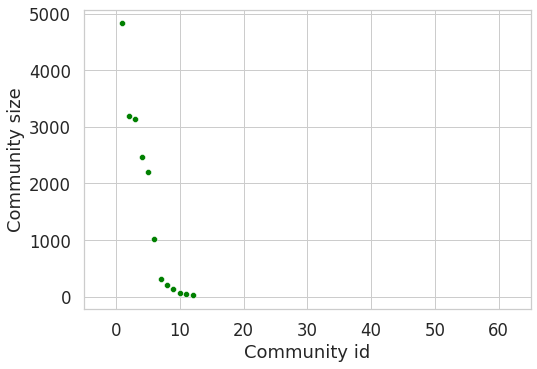

In [26]:
sns.set_style('whitegrid')
ax = sns.scatterplot(data=df, x='Community id', y='Community size', color='green')

ax.set(xlim=(-5, 65))
# ax.set(ylim=(-0.1, 3.2))
# ax.set(xticklabels=['',1,'',10,'',100,'',1000,'',10000])
# ax.set(yticklabels=['',1,'',10,'',100,'',1000])
sns.set(font_scale = 1.5)

# plt.savefig('../plots/community_size_distribution1.pdf', bbox_inches='tight')
plt.show()

In [27]:
user_communities_interactions_dict = {}
for userId in user_items_dict:
    if userId not in user_communities_interactions_dict:
        user_communities_interactions_dict[userId] = [0] * len(community_lists)
    for itemId in user_items_dict[userId]:
        user_communities_interactions_dict[userId][partition[itemId]] += 1

In [28]:
x = np.array(user_communities_interactions_dict['1'])
x

KeyError: '1'

In [25]:
np.sum(x/np.max(x))/x.shape[0]

NameError: name 'x' is not defined

In [29]:
user_diversities = {}
for userId in user_communities_interactions_dict:
    user_community_vector = np.array(user_communities_interactions_dict[userId])
    user_diversities[userId] = np.sum(user_community_vector/np.max(user_community_vector))/user_community_vector.shape[0]

In [30]:
x = np.array(user_diversities.values())

In [31]:
user_diversities_filtered = {}
for userId in user_diversities:
    if user_diversities[userId] > 0 and user_diversities[userId] <=1:
        user_diversities_filtered[userId] = user_diversities[userId]

In [32]:
user_diversities_df = pd.DataFrame({'userId':list(user_diversities_filtered.keys()), 'diversity':list(user_diversities_filtered.values())})

In [33]:
user_diversities_df

,userId,diversity
0,2,0.189394
1,3,0.148810
2,4,0.231481
3,5,0.160256
4,6,0.208333
...,...,...
1887,2095,0.092593
1888,2096,0.109649
1889,2097,0.115741
1890,2099,0.088652


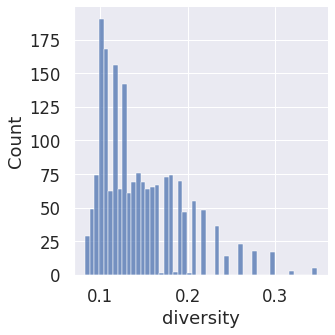

In [34]:
sns.displot(user_diversities_df, x="diversity", bins=50)

In [35]:
source_diversities = []
target_diversities = []
lastfm_social_filename = '../data/lastfm/processed/social_connections.tsv'
with open(lastfm_social_filename) as fr:
        for line in fr.readlines():
            tokens = line.split()
            source_user = tokens[0]
            target_user = tokens[1]
            if source_user in user_diversities_filtered and target_user in user_diversities_filtered:
                source_diversities.append(user_diversities_filtered[source_user])
                target_diversities.append(user_diversities_filtered[target_user])

In [36]:
source_diversities = np.array(source_diversities)
target_diversities = np.array(target_diversities)

In [37]:
from scipy.stats.stats import pearsonr
pearsonr(source_diversities, target_diversities)[0]

0.1823131644497978